In [1]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader


def load_data(path):
    """
    Helper method to load the dataset
    :param path: Path to location of dataset
    :return: lists of all the images and masks
    """
    images_list = list(path.glob('RGB/*.png'))
    images_list.sort()
    masks_list = list(path.glob('Semantic_array/*.npy'))
    masks_list.sort()
    if len(images_list) != len(masks_list):
        raise ValueError('Invalid data loaded')
    images_list = np.array(images_list)
    masks_list = np.array(masks_list)
    return images_list, masks_list


class SegmentationAgent:
    def __init__(self, val_percentage, test_num, num_classes,
                 batch_size, img_size, data_path, shuffle_data,
                 learning_rate, device):
        """
        A helper class to facilitate the training of the model
        """
        self.device = device
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_list, self.masks_list = load_data(data_path)
        train_split, val_split, test_split = self.make_splits(
                val_percentage, test_num, shuffle_data)
        #print(train_split)
        self.train_loader = self.get_dataloader(train_split)
        self.validation_loader = self.get_dataloader(val_split)
        self.test_loader = self.get_dataloader(test_split)
        self.model = SegmentationUNet(self.num_classes, self.device)
        self.criterion = TverskyCrossEntropyDiceWeightedLoss(self.num_classes,
                                                             self.device)
        #self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.model.to(self.device)

    def make_splits(self, val_percentage=0.2, test_num=10, shuffle=True):
        """
        Split the data into train, validation and test datasets
        :param val_percentage: A decimal number which tells the percentage of
                data to use for validation
        :param test_num: The number of images to use for testing
        :param shuffle: Shuffle the data before making splits
        :return: tuples of splits
        """
        if shuffle:
            shuffle_idx = np.random.permutation(range(len(self.images_list)))
            self.images_list = self.images_list[shuffle_idx]
            #print(shuffle_idx)
            self.masks_list = self.masks_list[shuffle_idx]

        val_num = len(self.images_list) - int(
            val_percentage * len(self.images_list))
        
        #print(val_num)

        train_images = self.images_list[:val_num]
        train_masks = self.masks_list[:val_num]

        #print(len(train_images))
        #print(len(train_masks))

        validation_images = self.images_list[val_num:-test_num]
        validation_masks = self.masks_list[val_num:-test_num]

        #print(len(validation_images))
        #print(len(validation_masks))

        test_images = self.images_list[-test_num:]
        test_masks = self.masks_list[-test_num:]

        #print(len(test_images))
        #print(len(test_masks))

        return (train_images, train_masks), \
               (validation_images, validation_masks), \
               (test_images, test_masks)

    def get_dataloader(self, split):
        """
        Create a DataLoader for the given split
        :param split: train split, validation split or test split of the data
        :return: DataLoader
        """
        return DataLoader(SegmentationDataset(split[0], split[1], self.img_size,
                                              self.num_classes, self.device),
                          self.batch_size, shuffle=True)

In [2]:
from numpy import array, moveaxis
from PIL import Image
from torch import from_numpy
from torch.utils.data import Dataset
import imageio as io

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size, num_classes, device):
        """
        Class extending the PyTorch Dataset class
        :param image_paths: list with paths to images
        :param mask_paths: list with paths to masks
        :param size: size to which the image is resized
        :param num_classes: number of classes to classify
        :param device: device on which the model is trained
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.size = size
        self.num_classes = num_classes
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = array(
                Image.open(self.image_paths[idx]).resize((self.size, self.size),
                                                         resample=Image.BILINEAR))
        image = image / 255
        image = image[:,:,:3]
        #image = image.reshape((128,128,3))
        # mask2 = array(
        #         Image.open(self.mask_paths[idx]).resize((self.size, self.size),
        #                                                 resample=Image.NEAREST),
        #         dtype='int')[:, :, 0]
        mask = np.load(self.mask_paths[idx]) 
        #print(mask)       
        # mask = io.imread(self.mask_paths[idx])
        # mask = mask[:,:,:3]

        # #mask = array(Image.open(self.mask_paths[idx]),dtype='int')[:,:,3]
    
        # for i in range(128):
        #     for j in range(128):
        #         if (mask[i][j]== [0,0,0]).all(): #Unlabeled
        #             mask[i][j][0]=0
        #         elif (mask[i][j]== [70,70,70]).all(): #Building
        #             mask[i][j][0]=1
        #         elif (mask[i][j]== [100,40,40]).all(): #Fence
        #             mask[i][j][0]=2
        #         elif (mask[i][j]== [55,90,80]).all(): #Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [220,20,60]).all(): #Pedestrian
        #             mask[i][j][0]=4
        #         elif (mask[i][j]== [153,153,153]).all(): #Pole
        #             mask[i][j][0]=5
        #         elif (mask[i][j]== [157,234,50]).all(): #Roadline
        #             mask[i][j][0]=6
        #         elif (mask[i][j]== [128,64,128]).all(): #Road
        #             mask[i][j][0]=7
        #         elif (mask[i][j]== [244,35,232]).all(): #Sidewalk
        #             mask[i][j][0]=8
        #         elif (mask[i][j]== [107,142,35]).all(): #vegetation
        #             mask[i][j][0]=9
        #         elif (mask[i][j]== [0,0,142]).all(): #vehicles
        #             mask[i][j][0]=10
        #         elif (mask[i][j]== [102,102,156]).all(): #wall
        #             mask[i][j][0]=11
        #         elif (mask[i][j]== [220,220,0]).all(): #TrafficSign
        #             mask[i][j][0]=12
                    
        #         elif (mask[i][j]== [70, 130, 180]).all(): #sky-> other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [81, 0, 81]).all(): #Ground-> Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [150, 100, 100]).all(): #Bridge -> Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [230, 150, 140]).all(): #Rail Track-> Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [180, 165, 180]).all(): #GuardRail-> Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [250, 170, 30]).all(): #Traffic Light-> Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [110, 190, 160]).all(): #Static-> Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [170, 120, 50]).all(): #Dynamic->Other
        #             mask[i][j][0]=3
        #         elif (mask[i][j]== [45,60,150]).all(): #water -> none
        #             mask[i][j][0]=0
        #         elif (mask[i][j]== [145, 170, 100]).all(): #terrain-> Other
        #             mask[i][j][0]=3
        #         else:
        #             print("NOT FOUND: {}".format(mask[i][j]))
        
        # mask = mask[:,:,0]
        
        #print(mask)
        #mask = array(mask.resize((self.size,self.size), resample=Image.NEAREST),dtype='int')[:,:,0]
        
        image = moveaxis(image, -1, 0)
        image = from_numpy(image).float().to(self.device)
        mask = moveaxis(mask, -1, 0)
        mask = from_numpy(mask).long().to(self.device)
        # mask2 = moveaxis(mask2, -1, 0)
        # mask2 = from_numpy(mask2).long().to(self.device)

        # print(mask.shape)
        # print(mask2.shape)
        #print(mask[:,:,0].shape)
        
        # print('image: {}'.format(image))
        # print('mask: {}'.format(mask))

        return image, mask

In [3]:
from torch import cat
from torch.nn import BatchNorm2d, Conv2d, ConvTranspose2d, MaxPool2d, Module, \
    ModuleList, Sequential
from torch.nn.functional import relu


def conv(in_channels, out_channels, kernel_size=3, padding=1, batch_norm=True):
    """
    A convolution block with a conv layer and batch norm
    :param in_channels: number of input channels
    :param out_channels: number of output channels
    :param kernel_size: size of the kernel
    :param padding: number of pixels to pad on all sides
    :param batch_norm: to use batch norm or not
    :return: PyTorch Tensor
    """
    c = Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1,
               padding=padding)
    if batch_norm:
        bn = BatchNorm2d(out_channels)
        return Sequential(c, bn)
    return c


class DownConv(Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        """
        A PyTorch Module to create the downward block of UNet architecture
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param pooling: to use pooling or not
        """
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv_in = conv(self.in_channels, self.out_channels)
        self.conv_out = conv(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = relu(self.conv_in(x))
        x = relu(self.conv_out(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(Module):
    def __init__(self, in_channels, out_channels):
        """
        A PyTorch Module to create the upward block of UNet architecture
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        """
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.upconv = ConvTranspose2d(self.in_channels, self.out_channels,
                                      kernel_size=2, stride=2)

        self.conv_in = conv(2 * self.out_channels, self.out_channels)
        self.conv_out = conv(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up, output_size=from_down.size())
        x = cat((from_up, from_down), 1)
        x = relu(self.conv_in(x))
        x = relu(self.conv_out(x))
        return x


class SegmentationUNet(Module):
    def __init__(self, num_classes, device, in_channels=3, depth=5,
                 start_filts=64):
        """
        The UNet model
        :param num_classes: number of classes to segment
        :param device: device on which the model is to be trained
        :param in_channels: number of input channels
        :param depth: the depth of the model
        :param start_filts: number of filters in the starting block
        """
        super(SegmentationUNet, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth
        self.device = device

        self.down_convs = []
        self.up_convs = []

        outs = 0
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts * (2 ** i)
            pooling = True if i < depth - 1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth - 1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs)
            self.up_convs.append(up_conv)

        self.conv_final = conv(outs, self.num_classes, kernel_size=1, padding=0,
                               batch_norm=False)

        self.down_convs = ModuleList(self.down_convs)
        self.up_convs = ModuleList(self.up_convs)

    def forward(self, x):
        x = x.to(self.device)
        encoder_outs = []

        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)
        return x

In [4]:
import numpy as np
import torch
from torch.nn import Module
from torch.nn.functional import cross_entropy, softmax


class TverskyCrossEntropyDiceWeightedLoss(Module):
    def __init__(self, num_classes, device):
        """
        A wrapper Module for a custom loss function
        """
        super(TverskyCrossEntropyDiceWeightedLoss, self).__init__()
        self.num_classes = num_classes
        self.device = device

    def tversky_loss(self, pred, target, alpha=0.5, beta=0.5):
        """
        Calculate the Tversky loss for the input batches
        :param pred: predicted batch from model
        :param target: target batch from input
        :param alpha: multiplier for false positives
        :param beta: multiplier for false negatives
        :return: Tversky loss
        """
        target_oh = torch.eye(self.num_classes)[target.squeeze(1)]
        target_oh = target_oh.permute(0, 3, 1, 2).float()
        probs = softmax(pred, dim=1)
        target_oh = target_oh.type(pred.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        inter = torch.sum(probs * target_oh, dims)
        fps = torch.sum(probs * (1 - target_oh), dims)
        fns = torch.sum((1 - probs) * target_oh, dims)
        t = (inter / (inter + (alpha * fps) + (beta * fns))).mean()
        return 1 - t

    def class_dice(self, pred, target, epsilon=1e-6):
        """
        Calculate DICE coefficent for each class
        :param pred: predicted batch from model
        :param target: target batch from input
        :param epsilon: very small number to prevent divide by 0 errors
        :return: list of DICE loss for each class
        """
        pred_class = torch.argmax(pred, dim=1)
        dice = np.ones(self.num_classes)
        for c in range(self.num_classes):
            p = (pred_class == c)
            t = (target == c)
            inter = (p * t).sum().float()
            union = p.sum() + t.sum() + epsilon
            d = 2 * inter / union
            dice[c] = 1 - d
        return torch.from_numpy(dice).float()

    def forward(self, pred, target, cross_entropy_weight=0.5,
                tversky_weight=0.5):
        """
        Calculate the custom loss
        :param pred: predicted batch from model
        :param target: target batch from input
        :param cross_entropy_weight: multiplier for cross entropy loss
        :param tversky_weight: multiplier for tversky loss
        :return: loss value for batch
        """
        if cross_entropy_weight + tversky_weight != 1:
            raise ValueError('Cross Entropy weight and Tversky weight should '
                             'sum to 1')
        ce = cross_entropy(pred, target,
                           weight=self.class_dice(pred, target).to(self.device))
        tv = self.tversky_loss(pred, target)
        loss = (cross_entropy_weight * ce) + (tversky_weight * tv)
        return loss

In [5]:
import torch
torch.cuda.empty_cache()

In [7]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/images/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy)
print(train_loss)
print(validation_loss)
print(validation_accuracy)

# # # Append episode reward to a list and log stats (every given number of episodes)
# writer.add_scalar("Average_Epsilon", np.array(train_accuracy), len(train_accuracy))
# writer.add_scalar('Episode Scores', np.array(train_loss), len(train_loss))
# writer.add_scalar('Episode Duration', np.array(validation_accuracy), len(validation_accuracy))
# writer.add_scalar('Route Completion %', np.array(validation_loss), len(validation_loss))

# #writer.flush()
# writer.close()

In [8]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/images/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 10  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_10.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy)
print(train_loss)
print(validation_loss)
print(validation_accuracy)

In [9]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/images/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 60  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy60 = []
validation_accuracy60 = []
train_loss60 = []
validation_loss60 = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy60.append(avg_accuracy)
    train_loss60.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy60.append(avg_accuracy)
    validation_loss60.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_10.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy60)) + 1, train_accuracy60, label='Train')
plt.plot(np.arange(len(validation_accuracy60)) + 1, validation_accuracy60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss60)) + 1, train_loss60, label='Train')
plt.plot(np.arange(len(validation_loss60)) + 1, validation_loss60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy60)
print(train_loss60)
print(validation_loss60)
print(validation_accuracy60)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
          DownConv-6  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        MaxPool2d-11          [-1, 128, 32, 32]               0
         DownConv-12  [[-1, 128, 32, 32], [-1, 128, 64, 64]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNo

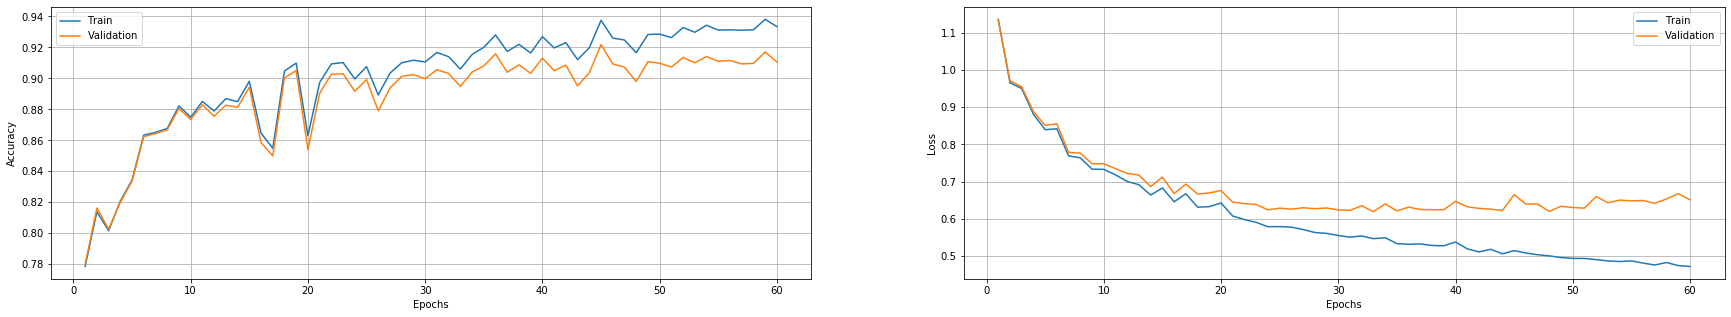

Test Accuracy: 0.908551025390625
Test Loss: 0.6419736742973328


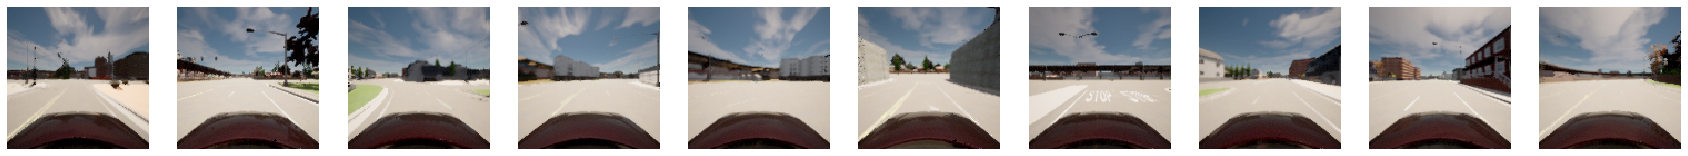

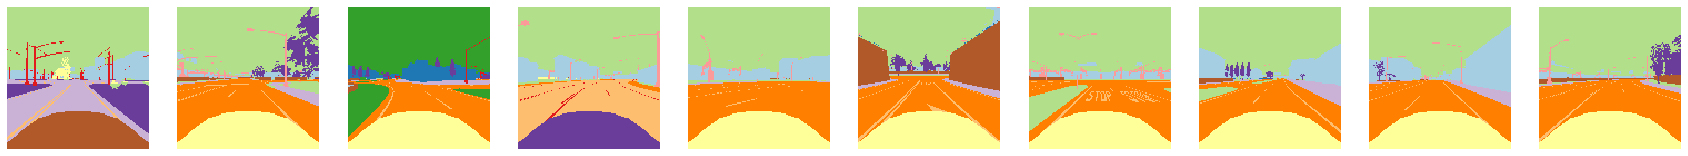

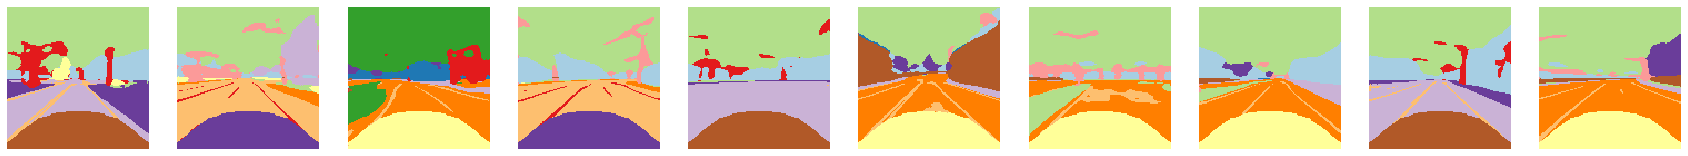

[0.7785975341796875, 0.813962646484375, 0.8016809285481771, 0.8207256673177084, 0.834409912109375, 0.8633643798828124, 0.8651416422526041, 0.8676233520507812, 0.8822002766927083, 0.8749298299153646, 0.8850882771809896, 0.8788948771158854, 0.8868956705729166, 0.8849290364583333, 0.8981115112304687, 0.8646442667643229, 0.8548698933919271, 0.9047263793945313, 0.909810791015625, 0.8629610392252605, 0.8972899169921875, 0.9093122151692709, 0.9101488240559896, 0.8996141967773438, 0.9075724690755208, 0.8892470703125, 0.9033398640950521, 0.9100441487630209, 0.9116857299804687, 0.9105469767252604, 0.9166875813802083, 0.9139648844401042, 0.9060027669270834, 0.9153371785481771, 0.920006123860677, 0.9280100504557292, 0.9173346557617188, 0.921911885579427, 0.9163547566731771, 0.9269480387369792, 0.9196214599609375, 0.9230192057291666, 0.9120624593098958, 0.9196736653645833, 0.9374412841796875, 0.9259817504882812, 0.9247380981445312, 0.9165133463541667, 0.9282832845052084, 0.928525858561198, 0.926264

In [10]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/images/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 60  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy60 = []
validation_accuracy60 = []
train_loss60 = []
validation_loss60 = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy60.append(avg_accuracy)
    train_loss60.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy60.append(avg_accuracy)
    validation_loss60.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_60.pth" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy60)) + 1, train_accuracy60, label='Train')
plt.plot(np.arange(len(validation_accuracy60)) + 1, validation_accuracy60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss60)) + 1, train_loss60, label='Train')
plt.plot(np.arange(len(validation_loss60)) + 1, validation_loss60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy60)
print(train_loss60)
print(validation_loss60)
print(validation_accuracy60)

# Sunny Unet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
          DownConv-6  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        MaxPool2d-11          [-1, 128, 32, 32]               0
         DownConv-12  [[-1, 128, 32, 32], [-1, 128, 64, 64]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNo

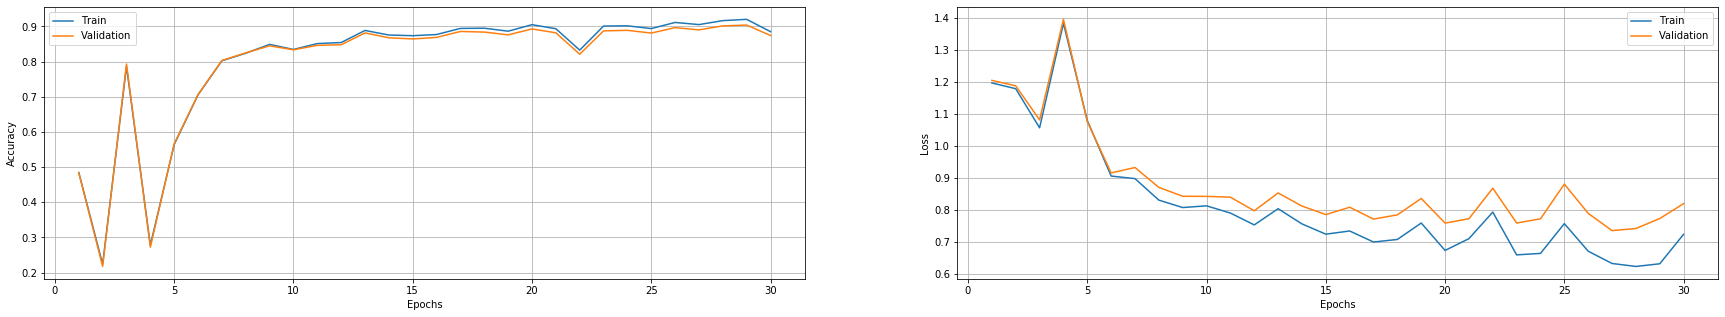

Test Accuracy: 0.859619140625
Test Loss: 0.8642104864120483


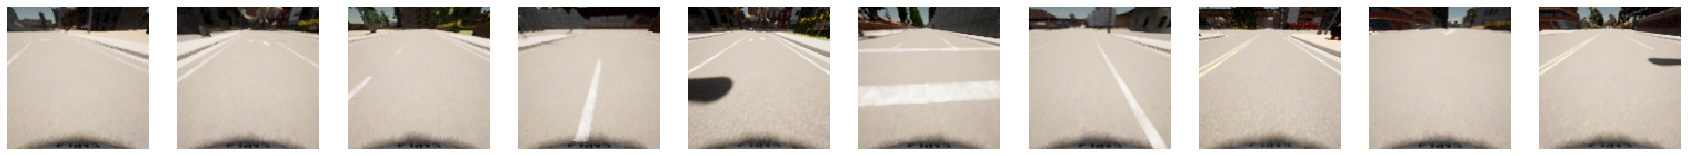

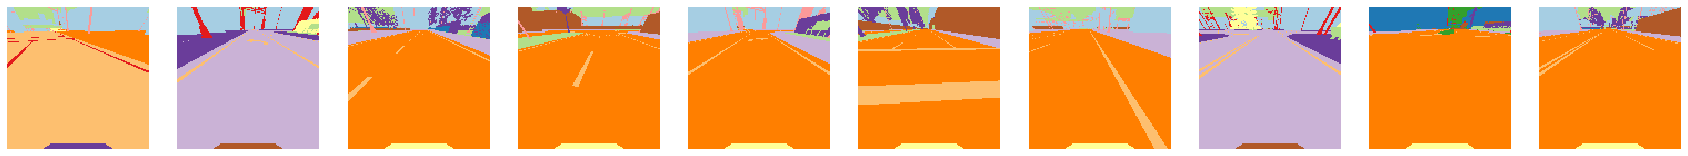

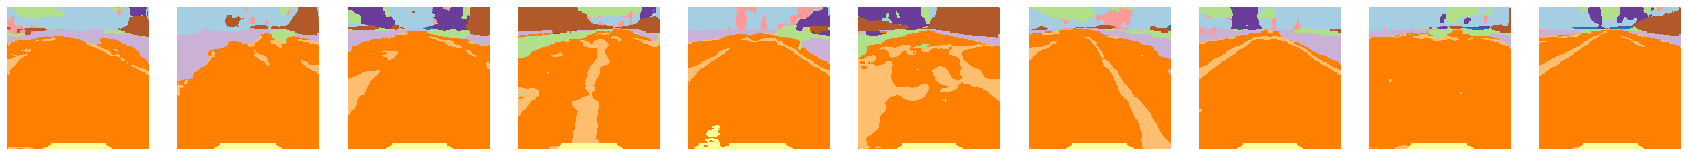

[0.4846405618270863, 0.22383092589852127, 0.7861375679196078, 0.27809246682200456, 0.5642667256396868, 0.7053988540573065, 0.8023243618488652, 0.823776932253507, 0.8488490532090444, 0.8344742704750044, 0.8511660114367405, 0.8541308410513648, 0.8885379597661834, 0.8755005624483448, 0.8736045679251921, 0.876925574105667, 0.8943226441389497, 0.8949214998017557, 0.8864084697775196, 0.904901402264173, 0.8934872390714349, 0.8325644895977595, 0.9010211980027587, 0.9016928464877256, 0.893905214278335, 0.9112759331791123, 0.905173355549723, 0.9164550432228378, 0.9200717143453471, 0.8851117235664984]
[1.1967667858459168, 1.1786979364445587, 1.056417251161544, 1.3832332455660292, 1.0793036460194783, 0.9054640033059328, 0.8974030871660561, 0.8301637225529396, 0.8069413071278592, 0.8122900634940136, 0.7896907389206577, 0.7526081513301912, 0.80330223317995, 0.7557214242036723, 0.7236301948378306, 0.7335917954789135, 0.6990462024353332, 0.7071397957246247, 0.7584697949707381, 0.6727466378747096, 0.70

In [7]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/Unet_images/Sunny/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy60 = []
validation_accuracy60 = []
train_loss60 = []
validation_loss60 = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy60.append(avg_accuracy)
    train_loss60.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy60.append(avg_accuracy)
    validation_loss60.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_Sunny.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy60)) + 1, train_accuracy60, label='Train')
plt.plot(np.arange(len(validation_accuracy60)) + 1, validation_accuracy60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss60)) + 1, train_loss60, label='Train')
plt.plot(np.arange(len(validation_loss60)) + 1, validation_loss60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy60)
print(train_loss60)
print(validation_loss60)
print(validation_accuracy60)

# Cloudy UNET

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
          DownConv-6  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        MaxPool2d-11          [-1, 128, 32, 32]               0
         DownConv-12  [[-1, 128, 32, 32], [-1, 128, 64, 64]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNo

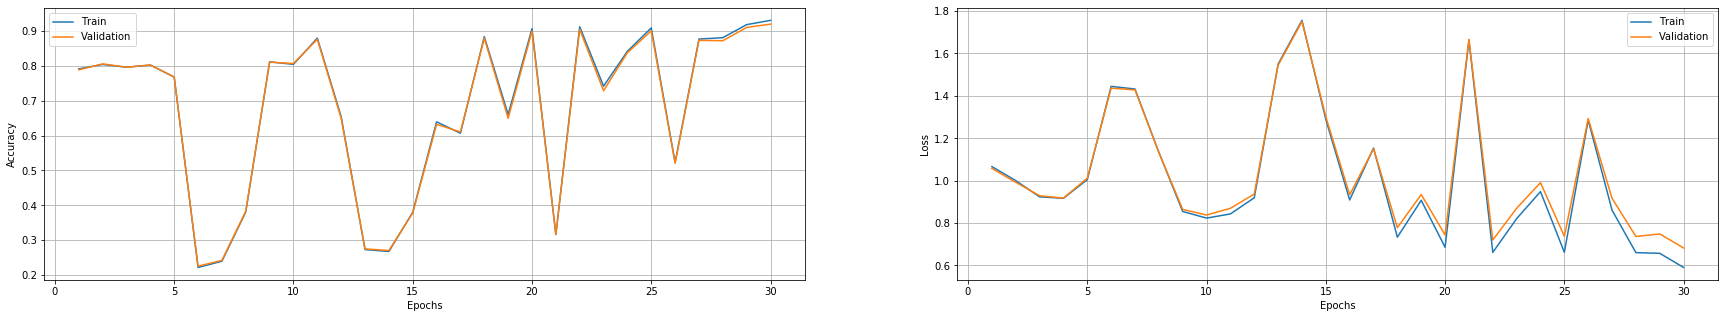

Test Accuracy: 0.94205322265625
Test Loss: 0.6566669344902039


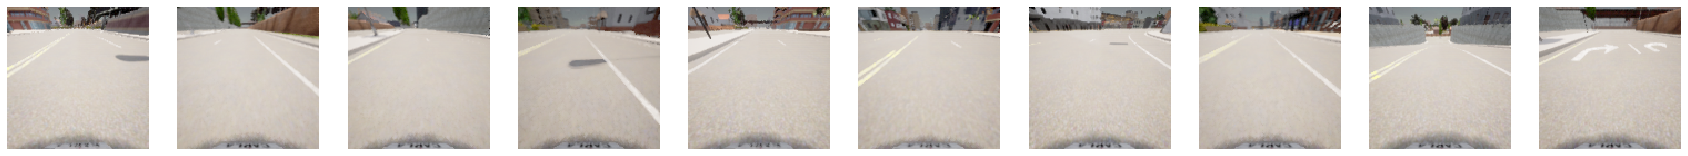

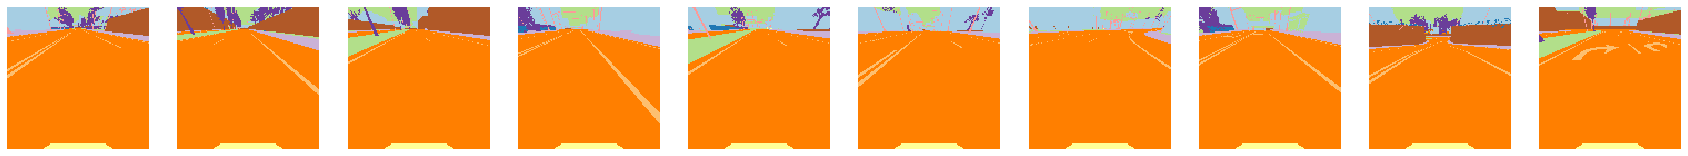

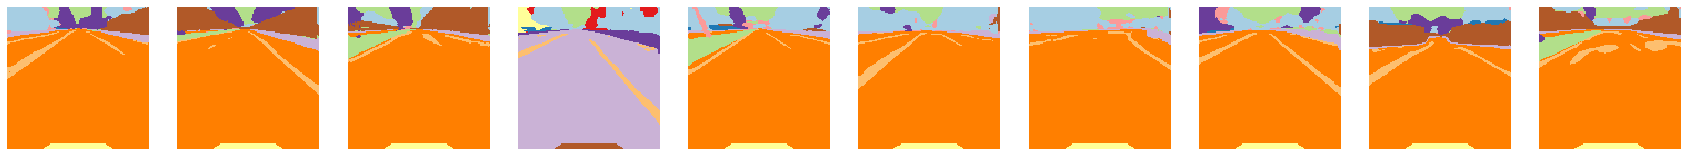

[0.7914543875812614, 0.8042452847000456, 0.7963637303261861, 0.8024552394003763, 0.767926782761177, 0.2210551463774521, 0.23890559064210767, 0.38036913349680657, 0.8117061420078695, 0.8045122578196282, 0.8799448277828467, 0.6539800268020073, 0.27243077633154655, 0.2669007015924384, 0.3794810496977646, 0.6393818430656935, 0.606565444834911, 0.8841078486755817, 0.6603700067005018, 0.907150669515568, 0.3154187056269959, 0.9125357968963845, 0.7418615188041743, 0.8419553659258098, 0.9092793931056113, 0.5224394860928946, 0.877228540573677, 0.8810923332715557, 0.9186387110800639, 0.9309164896498632]
[1.0660246243442062, 0.999964893647354, 0.9233816327839872, 0.916773975678604, 1.0046240590784672, 1.4440580270586223, 1.4316288634808394, 1.133352015140283, 0.8546146142221716, 0.8233196175011405, 0.8429180507242244, 0.9190114264940693, 1.5488530736770072, 1.7551886119981752, 1.2882016815408304, 0.9087300766993613, 1.1533865155964873, 0.7335199731979927, 0.9070740191605839, 0.6858380171504334, 1.

In [13]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/Unet_images/Cloudy/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy60 = []
validation_accuracy60 = []
train_loss60 = []
validation_loss60 = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy60.append(avg_accuracy)
    train_loss60.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy60.append(avg_accuracy)
    validation_loss60.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_Cloudy.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy60)) + 1, train_accuracy60, label='Train')
plt.plot(np.arange(len(validation_accuracy60)) + 1, validation_accuracy60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss60)) + 1, train_loss60, label='Train')
plt.plot(np.arange(len(validation_loss60)) + 1, validation_loss60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy60)
print(train_loss60)
print(validation_loss60)
print(validation_accuracy60)

# LIGHT RAIN UNET

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
          DownConv-6  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        MaxPool2d-11          [-1, 128, 32, 32]               0
         DownConv-12  [[-1, 128, 32, 32], [-1, 128, 64, 64]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNo

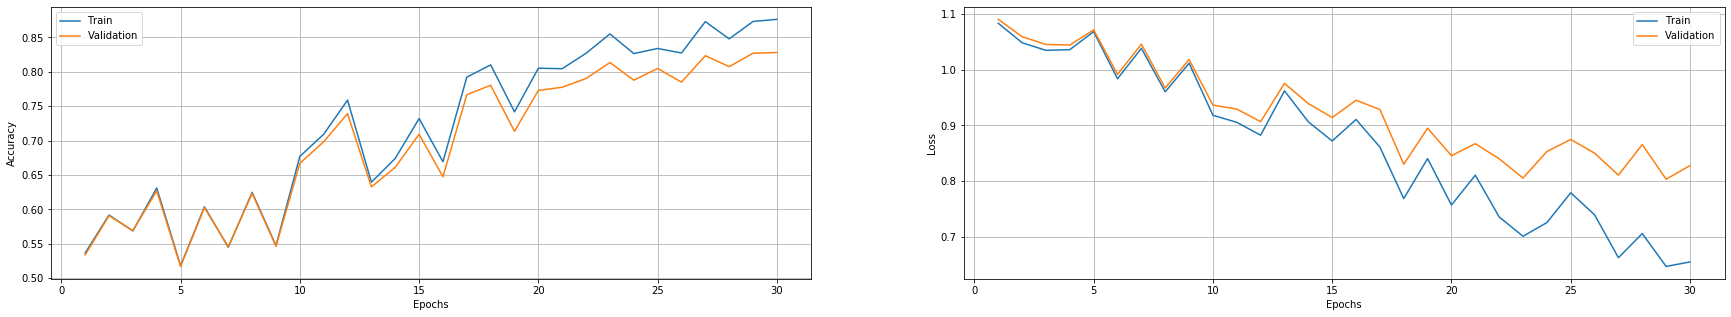

Test Accuracy: 0.77255859375
Test Loss: 0.8543059825897217


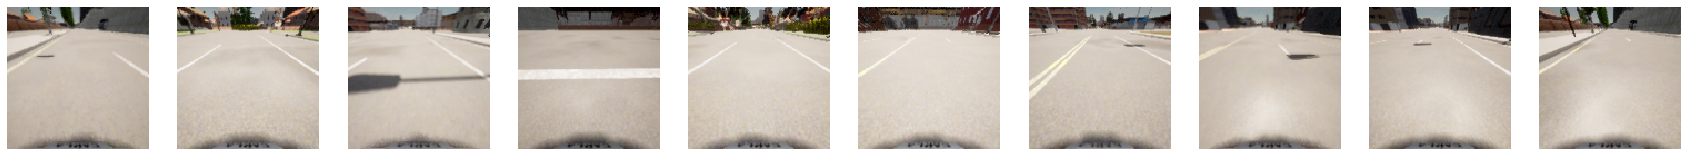

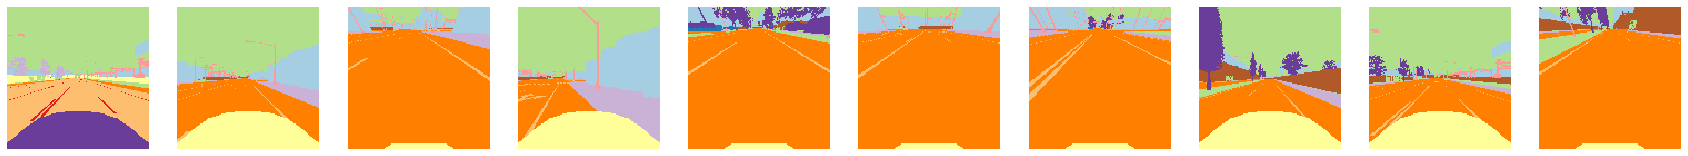

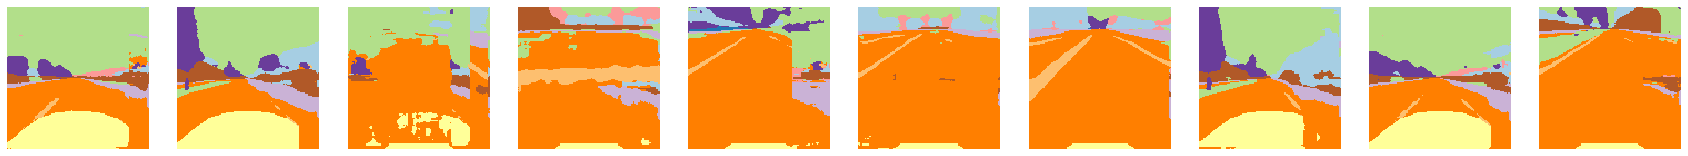

[0.5365712555796511, 0.5918167824687263, 0.5686425738006469, 0.6310743571293016, 0.5179869925927537, 0.6036916107301288, 0.5449734892439746, 0.6247272259793301, 0.5473820767421954, 0.6770218451496078, 0.709266878815315, 0.7588857272375933, 0.6395387533705245, 0.6741483433526537, 0.7320633552335052, 0.6692515693695439, 0.7922325288718529, 0.8101521542197779, 0.741845906987364, 0.8052453570037719, 0.8045866962386529, 0.8269986141065837, 0.8551183847280649, 0.8265714452334261, 0.8339698266403878, 0.8273997441959767, 0.8730142570217612, 0.847918058696546, 0.873275803168293, 0.8763144643683183]
[1.0831372959893724, 1.0482107309194713, 1.0345570182028088, 1.0358062002822939, 1.0680420910298583, 0.9836486322194459, 1.038177490234375, 0.9602436266447368, 1.011507165576765, 0.9181959638711412, 0.9055604509979125, 0.8824293623086412, 0.9619804722094826, 0.906439036010248, 0.872136289774165, 0.9106822766755757, 0.8611681857089765, 0.7688434307391827, 0.8405694382393408, 0.7572813458770875, 0.8107

In [10]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/Unet_images/Light_Rain/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy60 = []
validation_accuracy60 = []
train_loss60 = []
validation_loss60 = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy60.append(avg_accuracy)
    train_loss60.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy60.append(avg_accuracy)
    validation_loss60.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_LightRain.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy60)) + 1, train_accuracy60, label='Train')
plt.plot(np.arange(len(validation_accuracy60)) + 1, validation_accuracy60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss60)) + 1, train_loss60, label='Train')
plt.plot(np.arange(len(validation_loss60)) + 1, validation_loss60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy60)
print(train_loss60)
print(validation_loss60)
print(validation_accuracy60)

# HEAVY RAIN UNET

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
          DownConv-6  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        MaxPool2d-11          [-1, 128, 32, 32]               0
         DownConv-12  [[-1, 128, 32, 32], [-1, 128, 64, 64]]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNo

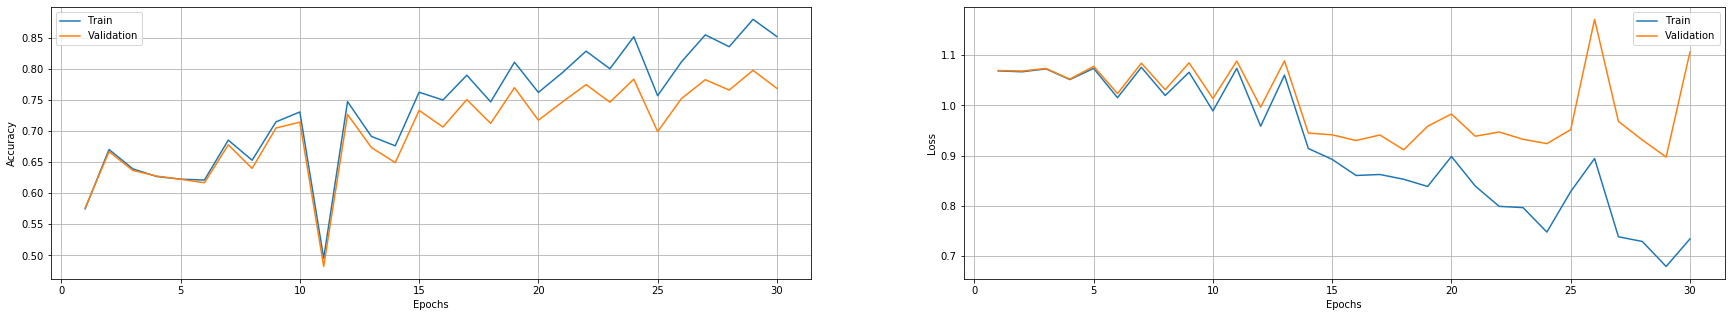

Test Accuracy: 0.78851318359375
Test Loss: 1.0458941459655762


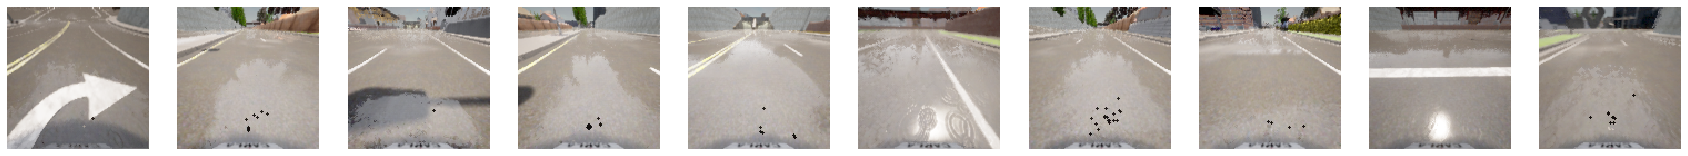

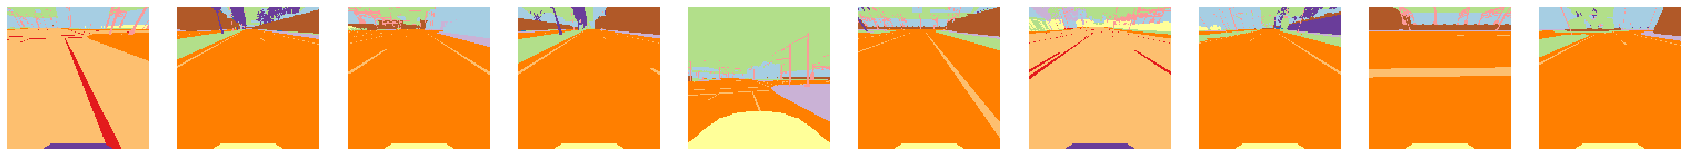

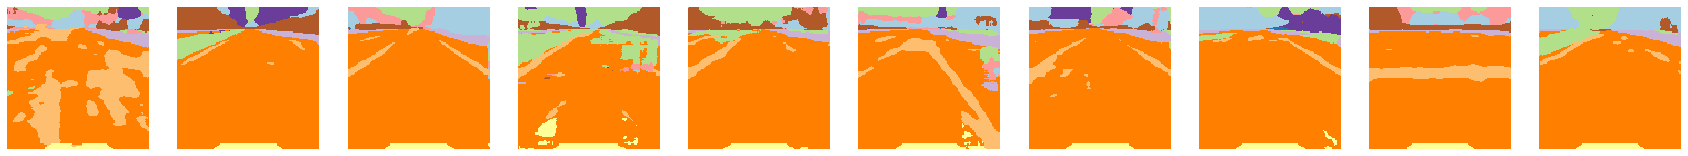

[0.5749677204369948, 0.6703548017330038, 0.6392494395478493, 0.6269006319464492, 0.622658646299437, 0.6212006954342884, 0.6854820198605297, 0.6531192206895929, 0.7148567464004764, 0.7308113926277425, 0.49518077401035654, 0.7474652931266238, 0.6914625066532549, 0.6762995977599957, 0.7625742288990329, 0.7500985583862586, 0.7899974655609483, 0.7470979404229214, 0.8109282390074697, 0.7622789484248701, 0.7938432865274971, 0.828755663724199, 0.8004202968253825, 0.8518713407098009, 0.7570004786960522, 0.8115257351282837, 0.8549698263613236, 0.835890039175267, 0.879923507302793, 0.8522195512097647]
[1.068878554416859, 1.067068756314954, 1.0729092992205542, 1.0515573127165128, 1.0738028651847575, 1.0154040893836604, 1.0759740816252887, 1.0197670458646073, 1.0661175663972287, 0.9890094994948037, 1.0738996192984989, 0.9585850669385104, 1.0603507731307737, 0.9140370710342091, 0.892367194266022, 0.8603026779914839, 0.8622182515697171, 0.8527202227374423, 0.8383475570150115, 0.8981603186345266, 0.83

In [11]:
from pathlib import Path

import numpy as np
import torch
from ignite.engine import Events, create_supervised_evaluator, \
    create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary
from datetime import date 
#from torch.utils.tensorboard import SummaryWriter

today  =date.today()
today_date =  today.strftime("%d/%m/%Y").replace("/", "")
#writer = SummaryWriter(log_dir=f"//home//dh26//Documents//Carla//gym-carla//Unet_{today_date}")

VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('/home/dh26/Documents/Carla/gym-carla/Unet_images/Heavy_Rain/')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train
# DEVICE = 'cpu'
agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy60 = []
validation_accuracy60 = []
train_loss60 = []
validation_loss60 = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy60.append(avg_accuracy)
    train_loss60.append(avg_loss)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy60.append(avg_accuracy)
    validation_loss60.append(avg_loss)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# # Save the model's weights after training is complete
path =  "//home//dh26//Documents//Carla//gym-carla//Models//Unet_HeavyRain.pt" 
torch.save(agent.model.state_dict(), path)

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy60)) + 1, train_accuracy60, label='Train')
plt.plot(np.arange(len(validation_accuracy60)) + 1, validation_accuracy60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss60)) + 1, train_loss60, label='Train')
plt.plot(np.arange(len(validation_loss60)) + 1, validation_loss60,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

print(train_accuracy60)
print(train_loss60)
print(validation_loss60)
print(validation_accuracy60)